# Happy Hotel
You've just joined the data team at a large hotelling chain. Your specific team is embedded in the CX (customer experience) division. Each day you receive hundreds of reviews of your 10 hotels from your customers. Each review consists of a free-form text review and a report of "happy" or "not happy". A product manager on your team wants to understand each hotel's performance at a more granular level; they want to build a product to identify topics within reviews. All of your reviews are unlabeled, and it's infeasible to label them by hand.

- Design and execute a method to identify topics within the reviews. 
- For each topic, find a robust means of assigning a score to each hotel in that topic. 
- For each of the ten hotels, what specific-to-that-hotel recommendations would you make to their general managers?

Engineering Challenge: 
- How would you design this system to update over time? 
- How would you persist topics from one timestep/update to another? 
- How would you design your scores so they can meaningfully understand when they’re doing better?








In [1]:
# !pip install -U pandas numpy matplotlib seaborn scikit-learn imblearn nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import string
import re
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline
plt.rcParams['font.size'] = 12
random_state = 5
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Dataset Information
Let's explore the dataset.

In [2]:
# Read the CSV file
df_happy = pd.read_csv('hotel_happy_reviews.csv', sep=',', header=0)
df_not_happy = pd.read_csv('hotel_not_happy_reviews.csv', sep=',', header=0)

# Print happy dataframe info
df_happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26521 entries, 0 to 26520
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User_ID      26521 non-null  object
 1   Description  26521 non-null  object
 2   Is_Response  26521 non-null  object
 3   hotel_ID     26521 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 828.9+ KB


In [3]:
# Print few lines from dataframe
df_happy

,User_ID,Description,Is_Response,hotel_ID
0,id10329,Stayed here with husband and sons on the way t...,happy,8
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3
...,...,...,...,...
26516,id49247,We staed at the Handlery Hotel to Visit San Di...,happy,5
26517,id49250,We booked a room with two single beds. Upon ar...,happy,3
26518,id49251,Arrived via taxi from La Guardia - driving int...,happy,8
26519,id49253,We arrived late at night and walked in to a ch...,happy,8


In [4]:
print(df_happy.Is_Response.value_counts(),'\n')
print(df_happy.hotel_ID.value_counts())

happy    26521
Name: Is_Response, dtype: int64 

5     5540
4     4651
8     4503
3     3470
7     3019
1     2179
2     1046
6      823
10     777
9      513
Name: hotel_ID, dtype: int64


In [5]:
# Print not happy dataframe info
df_not_happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12411 entries, 0 to 12410
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User_ID      12411 non-null  object
 1   Description  12411 non-null  object
 2   Is_Response  12411 non-null  object
 3   hotel_ID     12411 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 388.0+ KB


In [6]:
# Print few lines from dataframe
df_not_happy

,User_ID,Description,Is_Response,hotel_ID
0,id10326,The room was kind of clean but had a VERY stro...,not happy,3
1,id10327,I stayed at the Crown Plaza April -- - April -...,not happy,9
2,id10328,I booked this hotel through Hotwire at the low...,not happy,3
3,id10330,My girlfriends and I stayed here to celebrate ...,not happy,3
4,id10332,My husband and I have stayed in this hotel a f...,not happy,7
...,...,...,...,...
12406,id49249,I am pretty impartial to this hotel. I would d...,not happy,2
12407,id49252,I tend to post reviews only when I’ve had an e...,not happy,1
12408,id49254,The only positive impression is location and p...,not happy,2
12409,id49255,Traveling with friends for shopping and a show...,not happy,5


In [7]:
# Check value counts to find any unwanted value
print(df_not_happy.Is_Response.value_counts(),'\n')
print(df_not_happy.hotel_ID.value_counts())

not happy    12411
Name: Is_Response, dtype: int64 

7     2298
4     2196
1     1750
3     1612
5     1142
2     1012
8      850
10     734
9      483
6      334
Name: hotel_ID, dtype: int64


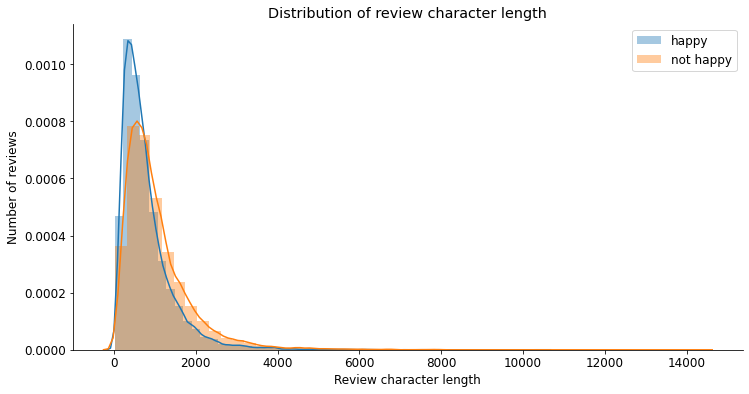

In [8]:
plt.figure(figsize=(12,6))
happy = [len(d) for d in df_happy.Description]
unhappy = [len(d) for d in df_not_happy.Description]
sns.distplot(happy, label='happy')
sns.distplot(unhappy, label='not happy')
plt.title('Distribution of review character length')
plt.ylabel('Number of reviews')
plt.xlabel('Review character length')
plt.legend()
sns.despine()

# TF-IDF

In [9]:
n_features = 1000
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                            max_features=n_features,
                            stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_happy.Description)
print(tfidf_vectorizer.get_feature_names())

['able', 'absolutely', 'access', 'accommodating', 'accomodating', 'actually', 'add', 'added', 'addition', 'additional', 'adequate', 'adults', 'advantage', 'advice', 'affordable', 'afternoon', 'ago', 'air', 'airport', 'allowed', 'amazing', 'amenities', 'american', 'anniversary', 'antonio', 'appointed', 'appreciated', 'area', 'areas', 'arrival', 'arrive', 'arrived', 'art', 'ask', 'asked', 'asking', 'ate', 'atmosphere', 'attached', 'attention', 'attentive', 'attractions', 'austin', 'available', 'ave', 'avenue', 'average', 'avoid', 'away', 'awesome', 'bad', 'bagels', 'bags', 'balcony', 'bar', 'bars', 'bart', 'base', 'based', 'basic', 'bath', 'bathroom', 'bathrooms', 'bay', 'beach', 'beat', 'beautiful', 'beautifully', 'bed', 'bedding', 'bedroom', 'beds', 'beer', 'believe', 'bell', 'bellman', 'best', 'better', 'big', 'bigger', 'birthday', 'bit', 'block', 'blocks', 'blue', 'board', 'bonus', 'book', 'booked', 'booking', 'boston', 'bother', 'bottle', 'boutique', 'brand', 'break', 'breakfast', '

Looks like, scikit-learn doesn't lemmatize words. Let's fix that:

In [10]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def remove_redundant_fullstops(self, text):
        if (text in ["'ll", "'re", "'ve", '-am', 
                    '-nd', '-pm', '-rd', '-th', 
                    '.', 'n\'t', "''", "'d", 
                    "'m", "'s", '--', '``']):
            text=''
        text = re.sub(r'(\.\s+)+', ".", 
                    re.sub(r'\.+', "", text))
        if len(text)<3 or text =='wa':
            text = ''

        return text
    def __call__(self, doc):
        result = [self.wnl.lemmatize(t) for t in\
            [self.remove_redundant_fullstops(i)\
            for i in word_tokenize(doc)\
            if i not in string.punctuation]]
        return result

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                            max_features=n_features,
                            stop_words='english',
                            tokenizer=LemmaTokenizer())
tfidf = tfidf_vectorizer.fit_transform(df_happy.Description)
print(tfidf_vectorizer.get_feature_names())

KeyboardInterrupt: 

In [21]:
n_top_words = 10
nmf = NMF(n_components=20, random_state=random_state,
          beta_loss='kullback-leibler', solver='mu', 
          max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(nmf.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([tfidf_feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)


Topics in NMF model (Frobenius norm):
Topic #0: wa room hotel review booked did stayed night given day
Topic #1: hotel location good price clean square bit great small walk
Topic #2: told hotel manager room called card reservation desk said check
Topic #3: room bathroom wall bed dirty small carpet floor shower window
Topic #4: breakfast parking free room coffee good day lot continental included
Topic #5: wa place hotel stay like night motel lot stayed money
Topic #6: just place service time really staff desk food did good
Topic #7: hotel lobby service room star ha area quality bathroom guest
Topic #8: noise wa door floor elevator window hear loud sleep street
Topic #9: wa parking car valet park view great garage location time
Topic #10: bed towel did bug sheet shower left clean went tub
Topic #11: pool nice room family area kid staff suite great friendly
Topic #12: room staff clean friendly desk helpful smell dirty rude need
Topic #13: wa water shower night hot stayed work bathroom da

In [23]:
# Assign topic to each review:
doc_topic = nmf.transform(tfidf)
topics = np.array([])
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topics = np.append(topics, [topic_most_pr], axis=0)
    # print("doc: {} topic: {}\n".format(n,topic_most_pr))
df_happy['topic_nmf'] = topics

ValueError: Length of values does not match length of index

In [14]:
# Use tf features for LDA.
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english',
                                tokenizer=LemmaTokenizer())
tf = tf_vectorizer.fit_transform(df_happy.Description)

lda = LatentDirichletAllocation(n_components=20, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=random_state,
                                n_jobs=-1)

lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([tf_feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)


Topic #0: service level meeting club group business season dallas treated spa
Topic #1: price worth paid reasonable road employee macy discount equipment selection
Topic #2: wa hotel room good great staff nice stay clean location
Topic #3: cool air interesting unit chance sent particular temperature hit heat
Topic #4: breakfast pool area coffee hot free kid nice wa fruit
Topic #5: wa room hotel did bed nice night good bathroom floor
Topic #6: fast quiet daily pas visited surprise allowed ticket manhattan minute
Topic #7: chose apartment pool pick wifi personal served child spotless checking
Topic #8: parking hotel inn san car street block union francisco walk
Topic #9: hotel room wa time location square new walk great block
Topic #10: airport shuttle cab train ride taxi free minute waiting harbor
Topic #11: cheap just saw upgrade daily truly fine knew finding touch
Topic #12: staff service stay hotel desk time year wa wonderful friendly
Topic #13: room view floor wa bar bathroom great 

In [15]:
# Assign topic to each review:
doc_topic = lda.transform(tf)
topics = np.array([])
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topics = np.append(topics, [topic_most_pr], axis=0)
    # print("doc: {} topic: {}\n".format(n,topic_most_pr))
df_happy['topic_lda'] = topics


# Unhappy Topics

In [16]:
tfidf_vectorizer_not_happy = TfidfVectorizer(max_df=0.95, min_df=2,
                            max_features=n_features,
                            stop_words='english',
                            tokenizer=LemmaTokenizer())
tfidf_not_happy = tfidf_vectorizer_not_happy.fit_transform(df_not_happy.Description)
print(tfidf_vectorizer_not_happy.get_feature_names())

['-night', 'a-c', 'able', 'absolutely', 'acceptable', 'access', 'accommodation', 'actually', 'add', 'added', 'addition', 'additional', 'adequate', 'adult', 'advance', 'afternoon', 'age', 'agent', 'ago', 'ahead', 'air', 'airport', 'alarm', 'allowed', 'amazing', 'amenity', 'annoying', 'answer', 'apart', 'apology', 'apparently', 'appeared', 'area', 'arrival', 'arrive', 'arrived', 'arriving', 'ask', 'asked', 'asking', 'ate', 'attached', 'attendant', 'attention', 'attitude', 'attraction', 'available', 'ave', 'avenue', 'average', 'avoid', 'aware', 'away', 'awesome', 'awful', 'bad', 'badly', 'bag', 'balcony', 'bar', 'barely', 'based', 'basic', 'basically', 'bath', 'bathroom', 'bathtub', 'bay', 'beach', 'beat', 'beautiful', 'bed', 'bedding', 'bedroom', 'beer', 'believe', 'bell', 'bellman', 'best', 'better', 'beware', 'big', 'bigger', 'biggest', 'birthday', 'bit', 'bite', 'black', 'blanket', 'block', 'board', 'book', 'booked', 'booking', 'boston', 'bother', 'bothered', 'bottle', 'boutique', 'bo

In [17]:
nmf_not_happy = NMF(n_components=20, random_state=random_state,
          beta_loss='kullback-leibler', solver='mu', 
          max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_not_happy)

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names_not_happy = tfidf_vectorizer_not_happy.get_feature_names()
for topic_idx, topic in enumerate(nmf_not_happy.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([tfidf_feature_names_not_happy[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)



Topics in NMF model (Frobenius norm):
Topic #0: wa room hotel review booked did stayed night given day
Topic #1: hotel location good price clean square bit great small walk
Topic #2: told hotel manager room called card reservation desk said check
Topic #3: room bathroom wall bed dirty small carpet floor shower window
Topic #4: breakfast parking free room coffee good day lot continental included
Topic #5: wa place hotel stay like night motel lot stayed money
Topic #6: just place service time really staff desk food did good
Topic #7: hotel lobby service room star ha area quality bathroom guest
Topic #8: noise wa door floor elevator window hear loud sleep street
Topic #9: wa parking car valet park view great garage location time
Topic #10: bed towel did bug sheet shower left clean went tub
Topic #11: pool nice room family area kid staff suite great friendly
Topic #12: room staff clean friendly desk helpful smell dirty rude need
Topic #13: wa water shower night hot stayed work bathroom da

In [18]:
# Assign topic to each review:
doc_topic = nmf_not_happy.transform(tfidf)
topics = np.array([])
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topics = np.append(topics, [topic_most_pr], axis=0)
    # print("doc: {} topic: {}\n".format(n,topic_most_pr))
df_not_happy['topic_nmf'] = topics

In [19]:
# Use tf features for LDA.
tf_vectorizer_not_happy = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english',
                                tokenizer=LemmaTokenizer())
tf_not_happy = tf_vectorizer_not_happy.fit_transform(df_not_happy.Description)

lda_not_happy = LatentDirichletAllocation(n_components=20, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=random_state,
                                n_jobs=-1)

lda_not_happy.fit(tf_not_happy)
tf_feature_names_not_happy = tf_vectorizer_not_happy.get_feature_names()
for topic_idx, topic in enumerate(lda_not_happy.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([tf_feature_names_not_happy[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

Topic #0: wa room service hotel floor did stayed smelled problem night
Topic #1: suite bedroom kid wa family screen flat kitchen area couch
Topic #2: wa room shower water bathroom did air floor hot work
Topic #3: hotel room service wa good location staff internet breakfast business
Topic #4: hotel stay wa place night stayed like room money worst
Topic #5: new towel wa york room door window hyatt glass bathroom
Topic #6: wa room hotel night nice did floor noise like stay
Topic #7: coffee maker cup tea breakfast juice cereal egg morning towel
Topic #8: inn hilton holiday breakfast resort property hampton seattle free member
Topic #9: bed sheet room pillow stain wall dirty wa carpet mattress
Topic #10: airport shuttle taxi motel driver cab flight free dog pick
Topic #11: choice kitchen screen updated dark truly felt later feeling toilet
Topic #12: parking car valet park garage lot fee free parked luggage
Topic #13: machine ice channel plaza elevator floor odd encountered wa basically
Topi

In [20]:
# Assign topic to each review:
doc_topic = lda.transform(tf)
topics = np.array([])
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topics = np.append(topics, [topic_most_pr], axis=0)
    # print("doc: {} topic: {}\n".format(n,topic_most_pr))
df_not_happy['topic_lda'] = topics